In [ ]:
# !pip install mlflow minio

In [ ]:
import os
from datetime import datetime
import tempfile
import shutil
import glob

import numpy as np
from sklearn.metrics import confusion_matrix
import librosa
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

import mlflow
from mlflow.tracking import MlflowClient

from minio import Minio

from dotenv import load_dotenv
load_dotenv()

In [3]:
def create_preprocessed_spectrogram(audio_path, sr=22050, n_mels=128, fmax=8000, img_size=(224, 224), start_time=20, segment_duration=20):
    """
    Create a preprocessed spectrogram from an audio file segment.
    Will generate a Mel spectrogram, plot it, and convert it to a tensor to be directly used with a model.

    Parameters:
    audio_path (str): Path to the audio file.
    sr (int, optional): Sampling rate for loading the audio. Default is 22050.
    n_mels (int, optional): Number of Mel bands to generate. Default is 128.
    fmax (int, optional): Maximum frequency for the Mel spectrogram. Default is 8000.
    img_size (tuple, optional): Size of the output image. Default is (224, 224).
    start_time (int, optional): Start time of the segment in seconds. Default is 20.
    segment_duration (int, optional): Duration of the segment in seconds. Default is 20.

    Returns:
    torch.Tensor: Preprocessed spectrogram as a tensor.
    """
    try:
        # Load the audio file
        y, sr = librosa.load(audio_path, sr=sr, offset=start_time, duration=segment_duration)

        # Generate the spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax)
        S_DB = librosa.power_to_db(S, ref=np.max)

        # Plot the spectrogram
        plt.figure(figsize=(10, 4))
        plt.axis('off')
        librosa.display.specshow(S_DB, sr=sr, x_axis=None, y_axis=None, fmax=fmax)

        # Save the plot to a temporary file
        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
            plt.savefig(tmpfile.name, bbox_inches='tight', pad_inches=0)
            plt.close()

            # Open the image and resize it
            img = Image.open(tmpfile.name).convert('RGB')  # Convert to RGB
            img = img.resize(img_size, Image.Resampling.LANCZOS)
            os.remove(tmpfile.name)

        # Transform the image to tensor
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

        return img_tensor
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


def split_dataset_into_train_val_test(dataset_dir, output_dirs, test_ratio=0.05, val_ratio=0.15):
    """
    Split the dataset into training, validation, and test sets.

    Parameters:
    dataset_dir (str): Path to the dataset directory containing genre subdirectories.
    output_dirs (list): List of output directories for train, test, and validation sets.
    test_ratio (float, optional): Proportion of the dataset to include in the test split. Default is 0.05.
    val_ratio (float, optional): Proportion of the remaining dataset to include in the validation split. Default is 0.15.

    Returns:
    None
    """
    train_dir, test_dir, val_dir = output_dirs

    # Create folders for train, test, and validation data
    for f in output_dirs:
        if os.path.exists(f):
            shutil.rmtree(f)
        os.makedirs(f)

    # Loop over all genres
    genres = list(os.listdir(dataset_dir))
    for g in genres:
        # Find all images & split into train, test, and validation
        src_file_paths = np.array(glob.glob(os.path.join(dataset_dir, f'{g}', "*.png")))
        np.random.shuffle(src_file_paths)

        num_files = len(src_file_paths)
        num_test = max(2, min(4, int(np.ceil(num_files * test_ratio))))

        test_files = src_file_paths[:num_test]
        remaining_files = src_file_paths[num_test:]

        num_remaining = len(remaining_files)
        num_val = int(np.ceil(num_remaining * val_ratio))

        val_files = remaining_files[:num_val]
        train_files = remaining_files[num_val:]

        # Make destination folders for train, test, and validation images
        for f in output_dirs:
            os.makedirs(os.path.join(f, g), exist_ok=True)

        # Copy training, testing, and validation images
        for f in train_files:
            shutil.copy(f, os.path.join(train_dir, g, os.path.basename(f)))
        for f in test_files:
            shutil.copy(f, os.path.join(test_dir, g, os.path.basename(f)))
        for f in val_files:
            shutil.copy(f, os.path.join(val_dir, g, os.path.basename(f)))

    print(f"Dataset created in {train_dir}, {test_dir}, {val_dir}")


In [ ]:
# PATH_TO_SPECTROGRAM_DATASET = "DATASET/spectrograms"
# NAME_OF_DATASET = "CNNSET"
# folder_names = [f'DATASET/{NAME_OF_DATASET}/train/', f'DATASET/{NAME_OF_DATASET}/test/', f'DATASET/{NAME_OF_DATASET}/val/']

# # split_dataset_into_train_val_test(PATH_TO_SPECTROGRAM_DATASET, folder_names)

In [ ]:
### DEFINE MODEL ###

In [5]:
class MusicNet(nn.Module):
    def __init__(self, num_classes=18):
        super(MusicNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)
        self.batchnorm4 = nn.BatchNorm2d(num_features=64)

        self.dropout = nn.Dropout(p=0.3, inplace=False)

        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))

        self.fc1 = nn.Linear(in_features=self._to_linear, out_features=num_classes)

    def convs(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [ ]:
### DATASET AND DATALOADER ###

In [7]:
folder_names = [f'/content/drive/MyDrive/Colab Notebooks/CNNSET/train/', f'/content/drive/MyDrive/Colab Notebooks/CNNSET/test', f'/content/drive/MyDrive/Colab Notebooks/CNNSET/val/']

In [8]:
folder_names

['/content/drive/MyDrive/Colab Notebooks/CNNSET/train/',
 '/content/drive/MyDrive/Colab Notebooks/CNNSET/test',
 '/content/drive/MyDrive/Colab Notebooks/CNNSET/val/']

In [9]:
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize (adjust mean and std as needed)
])

# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=25, shuffle=True, num_workers=2)

In [10]:
train_dataset.class_to_idx # Mapping of class names to indices

{'blues': 0,
 'chanson': 1,
 'classical': 2,
 'country': 3,
 'dance': 4,
 'dub': 5,
 'electro': 6,
 'folk': 7,
 'funk': 8,
 'hard rock': 9,
 'hip-hop': 10,
 'house': 11,
 'jazz': 12,
 'metal': 13,
 'pop': 14,
 'rap': 15,
 'reggae': 16,
 'rock': 17}

In [ ]:
### TRAIN MODEL AND LOG INTO MLFLOW ###

In [12]:
def get_current_time_string():
    # Get the current time
    now = datetime.now()
    # Format the time as a string with hours, minutes, seconds, and milliseconds
    time_string = now.strftime("%H:%M:%S.%f")[:-2]  # Remove the last 2 digits to get milliseconds
    return time_string

get_current_time_string()

'16:19:53.8364'

In [ ]:
MLFLOW_REMOTE_SERVER_URI = os.getenv("REMOTE_MLFLOW_STORAGE_URI")
REMOTE_MLFLOW_BUCKET_NAME = os.getenv("REMOTE_MLFLOW_BUCKET_NAME")
MLFLOW_TRACKING_USERNAME = os.getenv("MLFLOW_TRACKING_USERNAME")
MLFLOW_TRACKING_PASSWORD = os.getenv("MLFLOW_TRACKING_PASSWORD")
REMOTE_MLFLOW_STORAGE_URI = os.getenv("REMOTE_MLFLOW_STORAGE_URI")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

In [14]:
# Set the tracking URI to point to your MLflow server
mlflow.set_tracking_uri(MLFLOW_REMOTE_SERVER_URI)

# Set the environment variables for authentication
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD
os.environ['MLFLOW_S3_ENDPOINT_URL'] = f'https://{REMOTE_MLFLOW_STORAGE_URI}'
os.environ['AWS_ACCESS_KEY_ID'] = AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = AWS_SECRET_ACCESS_KEY
os.environ['MLFLOW_HTTP_REQUEST_TIMEOUT'] = '300'

# Create an MLflow client
mlflow_client = MlflowClient()
# Create a new experiment
experiment_name = f"Music_Genre_Classification_V2_{get_current_time_string()}"
experiment_id = mlflow_client.create_experiment(experiment_name)

In [15]:
def train_model(model, train_loader, val_loader, epochs, device, learning_rate=0.005):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    model.to(device)
    print(f"Training on {device}")

    with mlflow.start_run(experiment_id=experiment_id, run_name=f"Run at {get_current_time_string()}"):
        for epoch in range(epochs):
            model.train()
            running_loss, correct, total = 0.0, 0, 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            model.eval()
            running_loss, correct, total = 0.0, 0, 0

            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            val_loss.append(running_loss / len(val_loader))
            val_acc.append(correct / total)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')

            # Log metrics to MLflow
            mlflow.log_metric("train_loss", train_loss[-1], step=epoch)
            mlflow.log_metric("train_acc", train_acc[-1], step=epoch)
            mlflow.log_metric("val_loss", val_loss[-1], step=epoch)
            mlflow.log_metric("val_acc", val_acc[-1], step=epoch)

        # Log the model to MLflow
        mlflow.pytorch.log_model(model, "model")

        # Register the model
        run_id = mlflow.active_run().info.run_id
        model_name = f"MusicGenreModel_{get_current_time_string()}"
        model_uri = f"runs:/{run_id}/model"
        mlflow.register_model(model_uri, model_name)

        # Get the artifact URI
        artifact_uri = mlflow.get_artifact_uri("model")

    return {'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc, 'model_uri': model_uri, 'artifact_uri': artifact_uri}

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [17]:
# # Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicNet(num_classes=len(train_dataset.classes))
train_for_n_epochs = 100
learning_rate = 0.005

result_dict = train_model(
    model,
    train_loader,
    val_loader,
    epochs=train_for_n_epochs,
    learning_rate=learning_rate,
    device=device
    )

print()
for key, value in result_dict.items():
    print(f'{key}: {value}')


Epoch 10/100, Train Loss: 0.7247, Train Acc: 0.7652, Val Loss: 1.6632, Val Acc: 0.5364
Epoch 20/100, Train Loss: 0.1576, Train Acc: 0.9535, Val Loss: 1.8151, Val Acc: 0.6182
Epoch 30/100, Train Loss: 0.1403, Train Acc: 0.9611, Val Loss: 2.0190, Val Acc: 0.5961
Epoch 40/100, Train Loss: 0.1127, Train Acc: 0.9704, Val Loss: 2.1339, Val Acc: 0.6675
Epoch 50/100, Train Loss: 0.0780, Train Acc: 0.9811, Val Loss: 2.3174, Val Acc: 0.6208
Epoch 60/100, Train Loss: 0.0755, Train Acc: 0.9797, Val Loss: 2.6526, Val Acc: 0.6065
Epoch 70/100, Train Loss: 0.0896, Train Acc: 0.9771, Val Loss: 2.7065, Val Acc: 0.6299
Epoch 80/100, Train Loss: 0.0630, Train Acc: 0.9826, Val Loss: 2.6403, Val Acc: 0.6623
Epoch 90/100, Train Loss: 0.0831, Train Acc: 0.9807, Val Loss: 2.5063, Val Acc: 0.6390


2024/11/04 17:23:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 100/100, Train Loss: 0.0686, Train Acc: 0.9847, Val Loss: 2.2630, Val Acc: 0.6377


2024/11/04 17:23:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/11/04 17:23:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



train_loss: [5.731433045296442, 2.395770392957188, 2.05317270613852, 1.8365911011184965, 1.5879634104314304, 1.417365662753582, 1.2438432173359961, 1.0618096231704666, 0.8833356205196607, 0.7246761472807044, 0.5868163083103441, 0.46748007213075954, 0.4140408841582636, 0.37877509042265867, 0.2923457081695752, 0.2457593725328999, 0.25826888123438474, 0.19662293820597587, 0.1997529402364134, 0.15758196533092164, 0.17946904381859072, 0.14829161150624887, 0.15124149918777957, 0.13967690687665404, 0.16822275999722824, 0.1422253070105355, 0.1550589905846642, 0.12087246873194263, 0.10779632825662182, 0.14033176941302372, 0.13742399688566193, 0.12080876914218866, 0.14047305645432234, 0.1163959775790101, 0.11578470345245608, 0.12052772923613832, 0.10447630194193196, 0.10567795930823888, 0.1186004794376675, 0.11268784188273241, 0.12467366467206462, 0.084910523245829, 0.10300162452282773, 0.09848361119171993, 0.09296342064079086, 0.12050731154713071, 0.09629147685544533, 0.1212970568246549, 0.102

Successfully registered model 'MusicGenreModel_17:23:51.4818'.
Created version '1' of model 'MusicGenreModel_17:23:51.4818'.


In [19]:
# Save the model locally
name_of_model = f"music_net_{train_for_n_epochs}_{learning_rate}.pth"
torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/CNNSET/{name_of_model}")

# Load the model from local file
local_model = MusicNet(num_classes=len(train_dataset.classes))
local_model.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/CNNSET/{name_of_model}", weights_only=True))

<All keys matched successfully>

In [20]:
local_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

Test Accuracy: 0.6528


In [ ]:
# Evaluate the model and compute the confusion matrix
local_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

cm

array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,

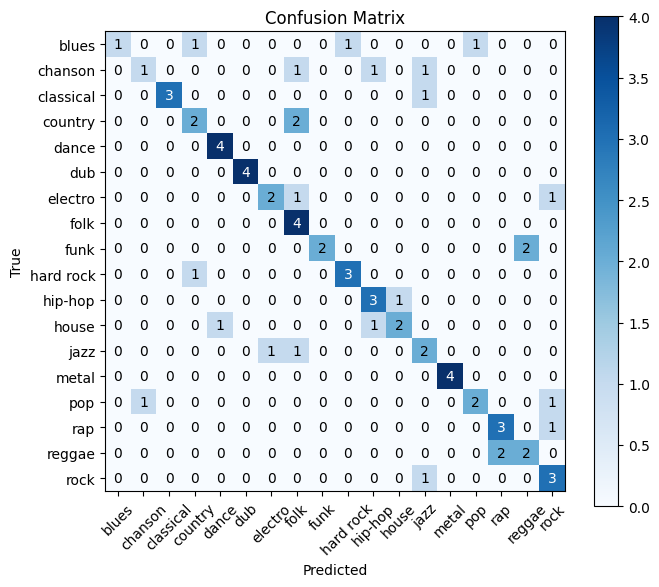

In [22]:
# Create a reverse mapping from index to class name
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Get the class names
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add labels to the plot
plt.xlabel('Predicted')
plt.ylabel('True')

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [29]:
def update_model_in_production_bucket(minio_client, bucket_name, model_folder_path):
    try:
        # Delete the existing model
        objects = minio_client.list_objects(bucket_name, prefix='data/', recursive=True)
        for obj in objects:
            minio_client.remove_object(bucket_name, obj.object_name)
    except Exception as e:
        return f"Error deleting existing model: {e}"

    # upload the new model's folder and all its contents
    if [obj for obj in minio_client.list_objects(bucket_name, recursive=True)] == []:
        try:
            # Upload the new model's folder and all its contents
            for root, dirs, files in os.walk(model_folder_path):
                for file in files:
                    local_file_path = os.path.join(root, file)
                    relative_path = os.path.relpath(local_file_path, model_folder_path)
                    minio_client.fput_object(bucket_name, f"data/{relative_path}", local_file_path)
        except Exception as e:
            return f"Error uploading new model: {e}"

    return "Model updated successfully"

In [ ]:
minio_client = Minio(
    endpoint=REMOTE_MLFLOW_STORAGE_URI,
    access_key=AWS_ACCESS_KEY_ID,
    secret_key=AWS_SECRET_ACCESS_KEY,
    secure=True
)

# List all objects in the bucket
objects = minio_client.list_objects(REMOTE_MLFLOW_BUCKET_NAME)

In [ ]:
update_model_in_production_bucket(
    minio_client,
    REMOTE_MLFLOW_BUCKET_NAME,
    "/content/minio.music-sim.fr/500397828407325387/0f5af0bfa25f41dfb788de287fd97a56/artifacts/model"

)

'Model updated successfully'